**Objective**: Exploring methods for building a model for identifying eating activity in Capture24

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import scipy.stats as stats
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from joblib import Parallel, delayed
import urllib
import shutil
from tqdm.auto import tqdm
import utils  # helper functions -- check out utils.py
import zipfile
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
# For reproducibility
np.random.seed(42)

In [2]:
from imblearn.over_sampling import SMOTE

### Load data

In [3]:
def load_all_and_make_windows(datafiles, N=999):
    def worker(datafile):
        X, Y, T = utils.make_windows(utils.load_data(datafile), winsec=30)
        pid = os.path.basename(datafile).split(".")[0]  # participant ID
        pid = np.asarray([pid] * len(X))
        return X, Y, T, pid
    results = Parallel(n_jobs=4)(
        delayed(worker)(datafile) for datafile in tqdm(datafiles[:N])
    )
    X = np.concatenate([result[0] for result in results])
    Y = np.concatenate([result[1] for result in results])
    T = np.concatenate([result[2] for result in results])
    pid = np.concatenate([result[3] for result in results])
    return X, Y, T, pid

In [14]:
# get all accelerometer data files

datafiles = os.path.expanduser("~/capture24/accelerometer/P[0-9][0-9][0-9].csv.gz")
X, Y, T, pid = load_all_and_make_windows(glob(datafiles))

# save the arrays for later
outputpath = os.path.expanduser("~/eating_detect/data/")
os.makedirs(outputpath + "processed_data/", exist_ok=True)
np.save(outputpath + "processed_data/X.npy", X)
np.save(outputpath + "processed_data/Y.npy", Y)
np.save(outputpath + "processed_data/T.npy", T)
np.save(outputpath + "processed_data/pid.npy", pid)


  0%|          | 0/151 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
# Load processed files
outputpath = os.path.expanduser("~/eating_detect/data/")
X = np.load(outputpath + 'processed_data/X.npy', mmap_mode='r')
Y = np.load(outputpath + 'processed_data/Y.npy')
T = np.load(outputpath + 'processed_data/T.npy')
pid = np.load(outputpath + 'processed_data/pid.npy')


In [5]:
print(X[1].shape)
print(X.shape)

(3000, 3)
(312730, 3000, 3)


In [6]:
import aiden_feature as af


In [26]:
X_feats = pd.DataFrame(Parallel(n_jobs=8)(delayed(af.aidan_features)(x, 100) for x in tqdm(X)))

  0%|          | 0/312730 [00:00<?, ?it/s]

/users/doherty/imh310/miniconda3/envs/eating_detect/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/users/doherty/imh310/miniconda3/envs/eating_detect/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/users/doherty/imh310/miniconda3/envs/eating_detect/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/users/doherty/imh310/miniconda3/envs/eating_detect/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/users/doherty/imh310/miniconda3/envs/eating_detect/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/users/doherty/imh310/miniconda3/envs/eating_detect/lib

In [31]:
X_feats.to_pickle(outputpath + 'processed_data/X_feats.pkl')

In [ ]:
def extract_features(xyz):
    ''' Extract features. xyz is an array of shape (N,3) '''

    feats = {}
    feats['xMean'], feats['yMean'], feats['zMean'] = np.mean(xyz, axis=0)
    feats['xStd'], feats['yStd'], feats['zStd'] = np.std(xyz, axis=0)
    v = np.linalg.norm(xyz, axis=1)  # magnitude stream
    feats['mean'], feats['std'] = np.mean(v), np.std(v)

    # auto correlation
    num_rows, num_columns = xyz.shape
    axis_names = ['X', 'Y', 'Z']
    for col in range(num_columns):
        time_series = xyz[:, col]
        variance = time_series.var()
        mean_centered = time_series - time_series.mean()
        autocorr_full = np.correlate(mean_centered, mean_centered, mode='full')
        feats['autocor'+ axis_names[col]] = np.mean(autocorr_full)

    # cross correlation
    for i in range(num_columns):
        for j in range(i+1, num_columns):
            feats['crosscor'+ axis_names[i] + axis_names[j]] = np.correlate(xyz[:, i], xyz[:, j])
    return feats

# Extract features
X_feats = pd.DataFrame(Parallel(n_jobs=4)(delayed(extract_features)(x) for x in tqdm(X)))
X_feats.to_pickle(outputpath + 'processed_data/X_feats.pkl')
print(X_feats)


  0%|          | 0/312730 [00:00<?, ?it/s]

           xMean     yMean     zMean      xStd      yStd      zStd      mean  \
0      -0.472182 -0.534437  0.655677  0.006469  0.006348  0.003302  0.968795   
1      -0.475536 -0.531443  0.656365  0.007745  0.004139  0.002418  0.969249   
2      -0.477615 -0.530214  0.656677  0.007741  0.004491  0.003096  0.969811   
3      -0.478286 -0.530208  0.656646  0.007620  0.004762  0.003020  0.970119   
4      -0.477083 -0.530458  0.656750  0.007806  0.004137  0.003163  0.969732   
...          ...       ...       ...       ...       ...       ...       ...   
312725  0.108823  0.343010  0.813089  0.004272  0.003462  0.005327  0.889182   
312726  0.109135  0.342750  0.813104  0.003862  0.003888  0.005163  0.889134   
312727  0.108943  0.342651  0.813172  0.003960  0.004016  0.005083  0.889135   
312728  0.109828  0.342396  0.812891  0.004674  0.005394  0.005798  0.888900   
312729  0.109615  0.342552  0.813000  0.003904  0.004235  0.005030  0.889022   

             std      autocorX      aut

In [5]:
# Let's map the text annotations to simplified labels
eat_indices = np.array([index for index, element in enumerate(Y) if 'eat' in element])

# Let's load the dictionary that maps the text labels to simplified labels
# and apply it to the Y array

# Load the dictionary
label_dict_path = os.path.expanduser("~/capture24/annotation-label-dictionary.csv")
anno_label_dict = pd.read_csv(
    label_dict_path,
    index_col='annotation', 
    dtype='string'
)

# remove the last bit of string after the last ";" in Y
#pattern = ";MET\ .*"
#Y = np.array([re.sub(pattern, '', element) for element in Y])


# apply the dictionary to simplify the labels
Y_simple = np.array([anno_label_dict.loc[y, 'label:Willetts2018'] for y in Y])


In [6]:
# get the unique labels related to eating
eating_labels = np.unique(Y[eat_indices])

# write the eating labels to a file for manual inspection
with open(outputpath + 'eating_labels.txt', 'w') as f:
    for item in eating_labels:
        f.write("%s\n" % item)

In [7]:
eating_label_dict['simple'].value_counts(dropna=False)

NameError: name 'eating_label_dict' is not defined

In [8]:
# after inspection, I have manually created a dictionary that maps the eating labels to
# simplified labels

eating_label_dict_path = os.path.expanduser("~/eating_detect/data/eating_labels_simple.tsv")
eating_label_dict = pd.read_csv(
    eating_label_dict_path,
    sep='\t',
    dtype='string'
)

# modify the Y_simple array to add eating-specific labels
# only replace with eating and maybe-eating lables, and ignore not-eating labels
Y_simple_eating = np.copy(Y_simple).astype('U12')
for i in eat_indices:
    label = Y[i]
    eating_label = eating_label_dict.loc[label, 'simple']
    if eating_label == 'eating' or eating_label == 'maybe-eating':
        Y_simple_eating[i] = eating_label
# the frequency of eating lables
pd.Series(Y_simple_eating).value_counts()

# remove records with the maybe-eating labels
rm_ind = np.where(Y_simple_eating == 'maybe-eating')[0]
X_simple_eating = np.delete(X, rm_ind, axis=0)
Y_simple_eating = np.delete(Y_simple_eating, rm_ind, axis=0)
T_simple_eating = np.delete(T, rm_ind, axis=0)
pid_simple_eating = np.delete(pid, rm_ind, axis=0)

In [9]:
# now let's read the features extracted from the accelerometer data
X_feats = pd.read_pickle(outputpath + 'processed_data/X_feats.pkl')
X_feats_eating = X_feats.drop(rm_ind, axis=0)

In [12]:
# Hold out participants P101-P151 for testing (51 participants)
test_ids = [f'P{i}' for i in range(101,152)]
mask_test = np.isin(pid_simple_eating, test_ids)
mask_train = ~mask_test
X_train, Y_train, T_train, pid_train = \
    X_feats_eating[mask_train], Y_simple_eating[mask_train], T_simple_eating[mask_train], pid_simple_eating[mask_train]
X_test, Y_test, T_test, pid_test = \
    X_feats_eating[mask_test], Y_simple_eating[mask_test], T_simple_eating[mask_test], pid_simple_eating[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (216425, 131)
Shape of X_test: (71011, 131)


In [62]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score


In [79]:
from sklearn.preprocessing import LabelEncoder
#X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)
xgb_clf = xgb.XGBClassifier(
    n_estimators=1000,
    use_label_encoder=True,
    eval_metric='logloss',  # Added to avoid a warning about the default metric
    n_jobs=8,
    verbosity=1
)
xgb_clf.fit(X_resampled, y_resampled_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=8, num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.7692751827181704

Classification Report:
               precision    recall  f1-score   support

   bicycling       0.93      0.90      0.92       374
      eating       0.42      0.20      0.27      2135
       mixed       0.55      0.63      0.59      9465
   sit-stand       0.76      0.79      0.78     23673
       sleep       0.92      0.93      0.93     27416
     vehicle       0.86      0.58      0.70      2770
     walking       0.45      0.41      0.43      5178

    accuracy                           0.77     71011
   macro avg       0.70      0.64      0.66     71011
weighted avg       0.77      0.77      0.77     71011



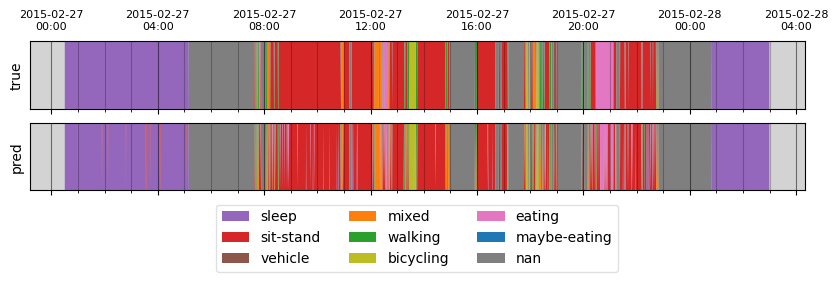

In [80]:
y_pred_encoded = xgb_clf.predict(X_test)
Y_test_pred = label_encoder.inverse_transform(y_pred_encoded)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_test_pred))

# Check again participant
mask = pid_test == 'P101'
fig, axs = utils.plot_compare(T_test[mask],
                              Y_test[mask],
                              Y_test_pred[mask])
fig.show()


In [42]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    oob_score=True,
    n_jobs=8,
    random_state=42,
    verbose=1
)

rf_clf.fit(X_resampled, y_resampled)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  4.7min finished


RandomForestClassifier(n_jobs=8, oob_score=True, random_state=42, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished



Classifier performance
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.84      0.91      0.87       374
      eating       0.26      0.32      0.28      2135
       mixed       0.57      0.63      0.60      9465
   sit-stand       0.78      0.74      0.76     23673
       sleep       0.93      0.92      0.92     27416
     vehicle       0.70      0.65      0.67      2770
     walking       0.47      0.49      0.48      5178

    accuracy                           0.76     71011
   macro avg       0.65      0.66      0.66     71011
weighted avg       0.77      0.76      0.76     71011



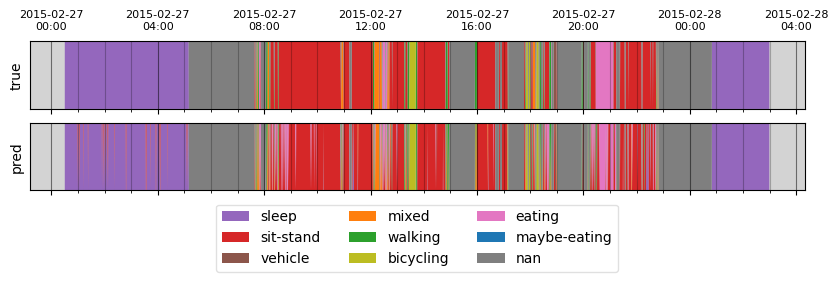

In [46]:
Y_test_pred = rf_clf.predict(X_test)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred))

# Check again participant
mask = pid_test == 'P101'
fig, axs = utils.plot_compare(T_test[mask],
                              Y_test[mask],
                              Y_test_pred[mask])
fig.show()

In [43]:
X_resampled.shape

(639702, 131)

### Train a random forest classifier

In [13]:
# Argument oob_score=True to be used for HMM smoothing (see later below)
clf = BalancedRandomForestClassifier(
    n_estimators=1000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=8,
    random_state=42,
    verbose=1
)
clf.fit(X_train, Y_train)
Y_test_pred = clf.predict(X_test)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred))



In [ ]:
## searching for the best parameters for max_depth and max_features
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, GroupKFold
param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'max_features': ['sqrt', 0.1, 0.2, 0.3, 0.4, 0.5 ]
}

group_kfold = GroupKFold(n_splits=2)
grid_clf = GridSearchCV(clf, param_grid, cv=group_kfold)
grid_clf.fit(X_train, Y_train, groups=pid_train)

# check the performance of all the parameters
Y_test_pred = grid_clf.predict(X_test)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred))



In [3]:
cv_results = grid_clf.cv_results_

# cv_results is a dictionary where each key is a string and each value is an array.
# The keys are metrics and the values are the results for each hyperparameter combination.

# For example, to print the mean test score for each parameter combination:
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(params, '->', mean_score)

NameError: name 'grid_clf' is not defined

### Model performance


In [ ]:
import importlib
importlib.reload(utils)

<module 'utils' from '/gpfs3/well/doherty/users/imh310/eating_detect/github/utils.py'>

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished



Classifier performance
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.53      0.93      0.67       374
      eating       0.15      0.54      0.24      2135
       mixed       0.61      0.52      0.56      9465
   sit-stand       0.78      0.60      0.68     23673
       sleep       0.93      0.89      0.91     27416
     vehicle       0.52      0.67      0.59      2770
     walking       0.47      0.61      0.53      5178

    accuracy                           0.71     71011
   macro avg       0.57      0.68      0.60     71011
weighted avg       0.76      0.71      0.72     71011



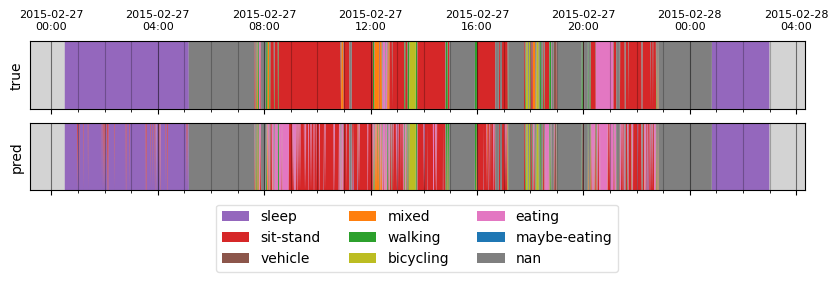

In [41]:
Y_test_pred = clf.predict(X_test)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred))

# Check again participant
mask = pid_test == 'P101'
fig, axs = utils.plot_compare(T_test[mask],
                              Y_test[mask],
                              Y_test_pred[mask])
fig.show()


In [38]:
X_feats.shape

(312730, 131)

### Rolling mode smoothing

In [81]:
def mode(alist):
    ''' Mode of a list, but return middle element if ambiguous '''
    m, c = stats.mode(alist)
    m, c = m.item(), c.item()
    if c==1:
        return alist[len(alist)//2]
    return m

def rolling_mode(t, y, window_size='100S'):
    y_dtype_orig = y.dtype
    # Hack to make it work with pandas.Series.rolling()
    y = pd.Series(y, index=t, dtype='category')
    y_code_smooth = y.cat.codes.rolling(window_size).apply(mode, raw=True).astype('int')
    y_smooth = pd.Categorical.from_codes(y_code_smooth, dtype=y.dtype)
    y_smooth = np.asarray(y_smooth, dtype=y_dtype_orig)
    return y_smooth



Classifier performance -- mode smoothing
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.92      0.92      0.92       374
      eating       0.56      0.21      0.31      2135
       mixed       0.56      0.73      0.64      9465
   sit-stand       0.78      0.84      0.81     23673
       sleep       0.95      0.94      0.94     27416
     vehicle       0.93      0.57      0.71      2770
     walking       0.49      0.32      0.39      5178

    accuracy                           0.80     71011
   macro avg       0.74      0.65      0.67     71011
weighted avg       0.80      0.80      0.79     71011



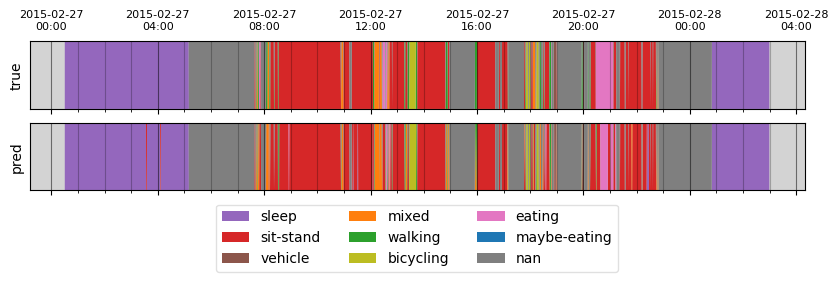

In [82]:
# Smooth the predictions of each participant
Y_test_pred_smooth = []
unqP, indP = np.unique(pid_test, return_index=True)
unqP = unqP[np.argsort(indP)]  # keep the order or else we'll scramble our arrays
for p in unqP:
    mask = pid_test == p
    Y_test_pred_smooth.append(rolling_mode(T_test[mask], Y_test_pred[mask]))
Y_test_pred_smooth = np.concatenate(Y_test_pred_smooth)

print('\nClassifier performance -- mode smoothing')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_smooth))

# Check again participant
mask = pid_test == 'P101'
fig, axs = utils.plot_compare(T_test[mask],
                              Y_test[mask],
                              Y_test_pred_smooth[mask])
fig.show()


### Hidden Markov Model


Classifier performance -- HMM smoothing
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.96      0.95      0.95       374
      eating       0.77      0.14      0.24      2135
       mixed       0.60      0.77      0.68      9465
   sit-stand       0.83      0.86      0.84     23673
       sleep       0.95      0.97      0.96     27416
     vehicle       0.99      0.73      0.84      2770
     walking       0.50      0.36      0.42      5178

    accuracy                           0.83     71011
   macro avg       0.80      0.68      0.71     71011
weighted avg       0.83      0.83      0.82     71011



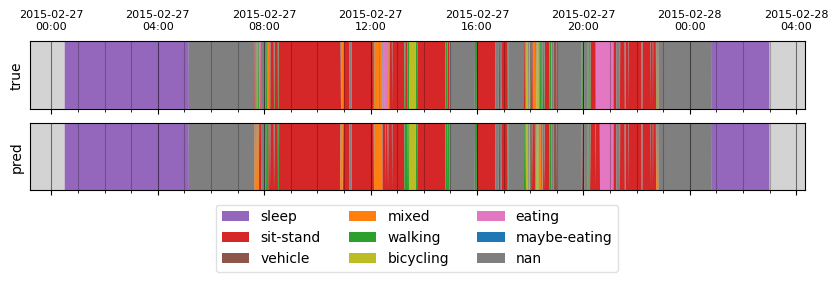

In [83]:
import importlib
importlib.reload(utils)
# Use the conveniently provided out-of-bag probability predictions from the
# random forest training process.
Y_train_prob = clf.oob_decision_function_  # out-of-bag probability predictions
labels = clf.classes_  # need this to know the label order of cols of Y_train_prob
hmm_params = utils.train_hmm(Y_train_prob, Y_train, labels)  # obtain HMM matrices/params
Y_test_pred_hmm = utils.viterbi(Y_test_pred, hmm_params)  # smoothing
print('\nClassifier performance -- HMM smoothing')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_hmm))

# Check again participant
mask = pid_test == 'P101'
fig, ax = utils.plot_compare(T_test[mask],
                             Y_test[mask],
                             Y_test_pred_hmm[mask])
fig.show()


In [93]:
probabilities = xgb_clf.predict_proba(X_test)
threshold = 0.4  # Example threshold
y_pred_adjust = (probabilities[:, 1] >= threshold).astype(int)
y_pred_adjust = label_encoder.inverse_transform(y_pred_adjust)
print('Out of sample:\n', metrics.classification_report(Y_test, y_pred_adjust))


/users/doherty/imh310/miniconda3/envs/eating_detect/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Out of sample:
               precision    recall  f1-score   support

   bicycling       0.01      1.00      0.01       374
      eating       0.40      0.22      0.28      2135
       mixed       0.00      0.00      0.00      9465
   sit-stand       0.00      0.00      0.00     23673
       sleep       0.00      0.00      0.00     27416
     vehicle       0.00      0.00      0.00      2770
     walking       0.00      0.00      0.00      5178

    accuracy                           0.01     71011
   macro avg       0.06      0.17      0.04     71011
weighted avg       0.01      0.01      0.01     71011



/users/doherty/imh310/miniconda3/envs/eating_detect/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/doherty/imh310/miniconda3/envs/eating_detect/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
y_pred_adjust


array(['bicycling', 'bicycling', 'bicycling', ..., 'bicycling',
       'bicycling', 'bicycling'], dtype='<U12')